# _Online Payment Fraud Detection_

**Fraud is one of the major issues we come up nowadays in banks, insurance companies, among others. Lately, one fraud that has ben increasing significantly is that occurring during payments.** 

**For this project, I will develop distinct classification models, using machine learning, that should help us detect fraud cases in the future.**

## Imports

In [1]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [41]:
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, classification_report

import xgboost as xgb

## Constants

**Colors**

In [3]:
# Payment method color list
payment_col = ['#8e44ad', '#1abc9c', '#f1c40f']

# Payment method color dictionary

payment_col_dict = {
    'paypal':'#8e44ad',
    'storecredit':'#1abc9c',
    'creditcard':'#f1c40f'
}

In [4]:
# Fraud label colors
fraud_col = ['#3498db','#e74c3c']

# Fraud label dictionary
fraud_col_dict = {
    0:'#3498db',
    1:'#e74c3c'
}

# Fraud Hue Order
fraud_order = [0, 1]

## Data Load

In [6]:
data = pd.read_csv('https://raw.githubusercontent.com/amankharwal/Website-data/master/payment_fraud.csv', sep = ',')

## Data Exploration and Transformation

**Dataset Size**

In [7]:
data.shape

(39221, 6)

In [8]:
data.columns

Index(['accountAgeDays', 'numItems', 'localTime', 'paymentMethod',
       'paymentMethodAgeDays', 'label'],
      dtype='object')

In [9]:
data.head(2)

,accountAgeDays,numItems,localTime,paymentMethod,paymentMethodAgeDays,label
0,29,1,4.745402,paypal,28.204861,0
1,725,1,4.742303,storecredit,0.000000,0


**Check Data Types**

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39221 entries, 0 to 39220
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   accountAgeDays        39221 non-null  int64  
 1   numItems              39221 non-null  int64  
 2   localTime             39221 non-null  float64
 3   paymentMethod         39221 non-null  object 
 4   paymentMethodAgeDays  39221 non-null  float64
 5   label                 39221 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 1.8+ MB


**Check null values**

In [11]:
data.isnull().sum()

accountAgeDays          0
numItems                0
localTime               0
paymentMethod           0
paymentMethodAgeDays    0
label                   0
dtype: int64

_**There are no null cases in the dataset**_

### Check Payment Method Values

In [12]:
data['paymentMethod'].unique()

array(['paypal', 'storecredit', 'creditcard'], dtype=object)

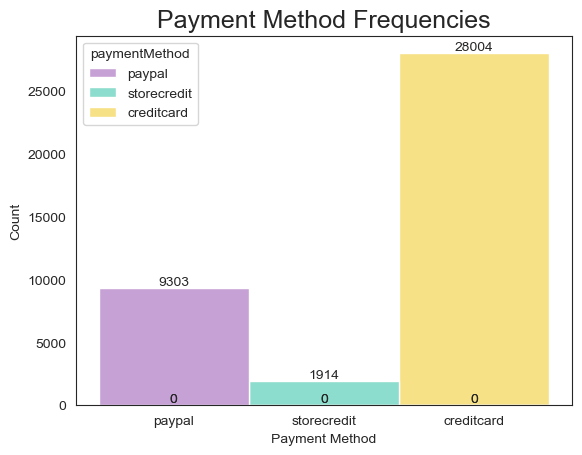

In [13]:
sns.set_style('white')

fig = sns.histplot(data=data, x='paymentMethod', stat='count', 
                   hue = 'paymentMethod', palette= payment_col_dict)

fig.set_title('Payment Method Frequencies', fontsize=18)
fig.set_xlabel('Payment Method')
fig.set_ylabel('Count')

for n in range(3):
    fig.bar_label(fig.containers[n])

### 'PaymentMethod' Label Encoding

In [14]:
label_encoder = LabelEncoder()

data['paymentEncoded'] = label_encoder.fit_transform(
    data['paymentMethod'])

print(data['paymentMethod'].value_counts())
print(data['paymentEncoded'].value_counts())

creditcard     28004
paypal          9303
storecredit     1914
Name: paymentMethod, dtype: int64
0    28004
1     9303
2     1914
Name: paymentEncoded, dtype: int64


#### PaymentMethod was encoded like this:
- **Credit Card** = 0 (28004 instances)
- **PayPal** = 1 (9303 instances)
- **Store Credit** = 2 (1914 instances)

**Fraud Count by Payment Method**

In [15]:
# Credit Card Fraud Count
card_fraud = (data['label'] == 1) & (data['paymentEncoded'] == 0)
card_fraud.value_counts()

False    38811
True       410
dtype: int64

In [16]:
# PayPal Fraud Count
paypal_fraud = (data['label'] == 1) & (data['paymentEncoded'] == 1)
paypal_fraud.value_counts()

False    39092
True       129
dtype: int64

In [17]:
# Store Credit Fraud Count
store_fraud = (data['label'] == 1) & (data['paymentEncoded'] == 2)
store_fraud.value_counts()

False    39200
True        21
dtype: int64

## Logistic Regression - Fraud Detection Model

**Check fraud labels distribution in data**

In [18]:
data.label.value_counts()

0    38661
1      560
Name: label, dtype: int64

The dataset seems to be unbalanced. Only 1.2% of the data are labelled as Fraud.

**Target variable**

In [19]:
y = data['label']

**Features**

In [20]:
X = data.drop(['paymentMethod','label'], axis=1, inplace = False)

**Split Dataset into Train and Test subsets**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"X Train subset size: {X_train.shape}")
print(f"X Test subset size: {X_test.shape}")
print(f"Y Train subset size: {y_train.shape}")
print(f"Y Test subset size: {y_test.shape}")

X Train subset size: (31376, 5)
X Test subset size: (7845, 5)
Y Train subset size: (31376,)
Y Test subset size: (7845,)


**Create and Train Model 1**

In [22]:
model1 = LogisticRegression()

In [23]:
model1.fit(X_train, y_train)

LogisticRegression()

**Make Predictions on Test Set**

In [24]:
y_pred1 = model1.predict(X_test)

**Model 1 Metrics**

_Accuracy Score_

In [25]:
acc1 = accuracy_score(y_pred1, y_test)
print(f"Accuracy Score of Model 1: {acc1.round(2)}")

Accuracy Score of Model 1: 1.0


Logistic regression models tend to overfit the data, particularly in high-dimensional settings.
I will try to avoid overfitting using a **Regularization** method

## Ridge Regularization (L2) - Logistic Regression


**Create and Train Model 2**

In [26]:
# Create LogisticRegression() model with L2 Regularization (parameter C controls the strength of regularization)

reg_model2 = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=42)

# Train model2 with train subset
reg_model2.fit(X_train, y_train)


LogisticRegression(random_state=42, solver='liblinear')

**Make Predictions on Test Set**

In [27]:
y_pred2 = reg_model2.predict(X_test)

**Model 2 Metrics**

_Accuracy Score_

In [28]:
acc2 = accuracy_score(y_test, y_pred2)
print(f"Accuracy Score of Model 2: {acc2.round(2)}")

Accuracy Score of Model 2: 1.0


**Confusion Matrix**

In [29]:
confusion_mat = confusion_matrix(y_test, y_pred2)
print("Confusion Matrix:")
print(confusion_mat)

Confusion Matrix:
[[7727    0]
 [   0  118]]


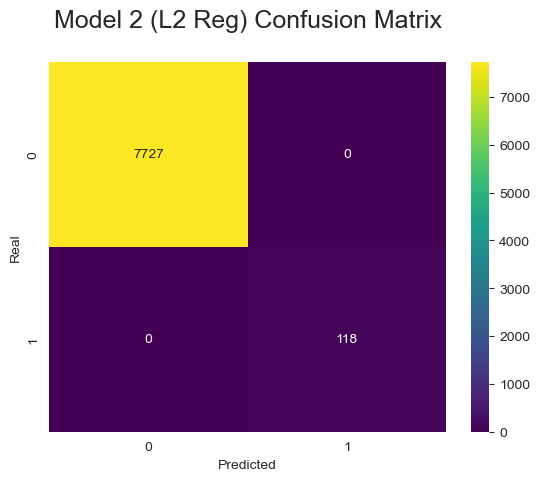

In [30]:
sns.heatmap(confusion_mat, annot = True, fmt="d", cmap="viridis")

plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Model 2 (L2 Reg) Confusion Matrix\n", fontsize = 18)

plt.show()

## Hyperparameter Tuning - XGBoost & Randomized Search CV

**Create XGBoost Classifier model**

In [31]:
boost = xgb.XGBClassifier()

**Defining my Hyperparameters to Tune**

In [33]:
param_dict = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 1.0], # Learning Rate
    'n_estimators': [50, 75, 100], # Nr of trees to be built
    'subsample': [0.5, 0.9, 1.0], # Portion of used samples
    'gamma': [0, 1, 5] # Minimum Loss per Partition
}

**Randomized Search with Cross Validation, looking for the best hyperparameter combination for my classification model**

In [34]:
random_search = RandomizedSearchCV(boost, param_dict, scoring = 'accuracy',
                                   cv = 15, n_iter = 25)

**Train my model with previous train subsets**

In [35]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=15,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           max_delta_step=None, max_depth=None,
               

**Exploring which are the best parameters and the best model according to my search**

In [36]:
best_params = random_search.best_params_
best_model = random_search.best_estimator_

**Predicting using best model**

In [37]:
y_pred3 = best_model.predict(X_test)

**Estimating accuracy for best_model**

In [38]:
acc3 = accuracy_score(y_test, y_pred3)
print(f"Accuracy Score of Model 3: {acc3.round(2)}")

Accuracy Score of Model 3: 1.0


**Estimating Confusion Matrix**

In [39]:
confusion_mat3 = confusion_matrix(y_test, y_pred3)

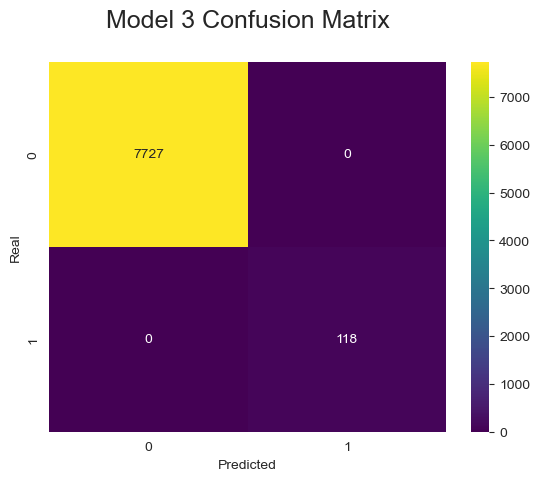

In [40]:
sns.heatmap(confusion_mat3, annot = True, fmt="d", cmap="viridis")

plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Model 3 Confusion Matrix\n", fontsize = 18)

plt.show()

**Classification Report**

In [42]:
class_rep = classification_report(y_test, y_pred3)
print("Classification Report: \n")
print(class_rep)

Classification Report: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7727
           1       1.00      1.00      1.00       118

    accuracy                           1.00      7845
   macro avg       1.00      1.00      1.00      7845
weighted avg       1.00      1.00      1.00      7845



## Conclusion

**Apparently, Model 1 seems to be overfitted because of the 100% prediction accuracy, but as I use Ridge Regularization on Model 2 Logistic Regression for penalizing, we get the same accuracy. The same thing occurs when I created and trained a XGBoost model optimized using Randomized Search. Having 100% accuracy in prediction makes even more sense when I check the confusion matrix of each model.**

**Either way, I would tend to use Model 3, since it is methodologically more adequate and reliable, since it should account for overfitting as well.**